## Assignment 5: Design Optimization 

#### Justin Hanson

### Introduction

In this assignment the goat is to create a simulation that could find the optimal stiffness and dampening(as it relates to stiffness) of a hinged joint, that could make a weighted body go as high as possible. 

In [54]:
import os
import mujoco
import numpy
import mediapy as media
import matplotlib.pyplot as plt
import math

First step like always was just to import the necessary libraries for the assignment.

### Part 0. Create the simulated block, leg, and motor

In [55]:
Vrom = 6
R = Vrom / 0.6
G = 55.5
t_stall = 15/100/G
i_stall = .6
i_nl = .2
w_nl = .66*1000*2*math.pi/180*G

kt = t_stall/i_stall
ke = kt

b_calc = kt*i_nl/w_nl
ts = 1e-4

V_control = 5
b_fit = 1.404e-6
kp_fit = 8.896



First to create the simulated environment we need to know the exact parameters for the motors that we will be using. This data has been provided to us in the textbook and through parameter identification.

In [56]:
framerate = 30
data_rate = 100
width = 800
height = 600


Next we simply set the parameters for the camera

In [57]:
xml_template = '''
<mujoco>
    <option><flag gravity="enable" contact="enable"/></option>
    <option timestep="{ts:e}"/>
    <compiler angle="degree" />
    <visual><global offwidth="{width}" offheight="{height}" /></visual>

    <default>
        <geom contype="1" conaffinity="1" condim="3" friction=".6 .3 .3" solimp=".999 .999 .001" solref=".001 1" margin="0.001" group="0"/>
    </default>

    <worldbody>
        <light name="top" pos="0 0 1"/>
        <body name="floor" pos="0 0 0">
            <geom name="floor" pos="0 0 0" size="1 1 .05" type="plane" rgba="1 .83 .61 .5"/>
        </body>
        <body name="trunk" pos="0 0 .05">
            <joint name="joint1" type="slide" axis="0 0 1"/>
            <geom name="trunk" pos="0 0 0" size=".025 .025 .025" type="box" rgba="1 1 0 1" mass=".01"/>
            <body name="leg_link1" pos="0.025 0 -0.025">
                <joint name="joint2" type="hinge" axis="0 1 0" limited="true" range="0 180"/>
                <geom name="leg_link1" pos="0.025 0 0" size=".025 .0125 .001" type="box" rgba="0.66 0 1 0.66" mass=".001"/>
                <body name="leg_link2" pos=".05 0 .0">
                    <joint name="joint3" type="hinge" axis="0 1 0" stiffness="{k:e}" damping="{b:e}"/>
                    <geom name="leg_link2" pos="0.025 0 0" size=".025 .0125 .001" type="box" rgba="1 0 0 1" mass=".001"/>
                    
                </body>
            </body>
        </body>
    </worldbody>
    <actuator>
    <motor name="motor1" joint="joint2" />

    
    </actuator>
    
</mujoco>
'''

This XML Generates 1 cube, 1 leg link attached to the bottom edge, and another equal-sized leg connected to the end of the previous one. Finally, it sets a motor to actuate on the connection between the block and the joints. The motor has 180 degrees of motion like a normal servo. Multiple parameters are waiting to be changed when formatting the XML, specifically the width and height of the camera's view, and the stiffness and damping of the leg links. 

In [58]:
def run_sim(k, b, render=False):
    xml = xml_template.format(k = k, b = b, width = width, height = height, ts = ts)
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model,width=width, height=height)
    #print(k)
    def my_controller(model, data):
        w = data.qvel[1]
        actual = data.qpos[1]
        if data.time>1:
            desired = math.pi
        else:
            desired = 0

        error = desired-actual
        V = kp_fit*error
        if V>V_control: V=V_control
        if V<-V_control: V=-V_control

        torque = (kt*(V-(ke)*w*G)/R - b_fit*w*G)*G

        data.ctrl[0] = torque

        return
    try:
        mujoco.set_mjcb_control(my_controller)
        duration = 5

        frames = []
        t = []
        xy = []

        mujoco.mj_resetData(model,data)

        while data.time<duration:
            mujoco.mj_step(model,data)

            if render:
                if len(frames)<data.time*framerate:
                    renderer.update_scene(data)
                    pixels = renderer.render()
                    frames.append(pixels)

            if len(xy)<data.time*data_rate:
                t.append(data.time)
                xy.append(data.xpos.copy())

        if render:
            media.show_video(frames, fps=framerate, codec='gif')
        t = numpy.array(t)
        xy = numpy.array(xy)
    finally:
        mujoco.set_mjcb_control(None)
    
    return t,xy,frames

        

The above box describes the code used to run the simulation, Which for the first few lines is just copying code from previous XML assignments, however, things change in the my_Controller function which takes the information from the motor, that we defined earlier. The function takes this information including the velocity of the first joint (the actuated motor), gear ratio of the servo, torque constant of the servo, and the damping value that fit the servo in the parameter identification. The torque expression generally is multiplying the torque constant of the motor by the current going through the motor, this gives the torque, then we take the damping times the current speed multiplied by the gear ratio to get the torque at the motor. This is all multiplied by the gear ratio in order to find the torque applied to the end effector of the servo. This final torque is imput into the system in order to actuate the motor closer to how it would really move in reality with our specific servo. The rest of the code is generally the same as usual, running the video if render is true, resetting the data when the simulation is over, and collecting data about the location of the main body of the system for later use.

### Arbitrary Result

Below, to test the simulation I looked at how high the block would move when the stiffness is 10^-3 and damping was 10^-5 Damping is k/100 because that is how it is specified to be in the assignment.

""

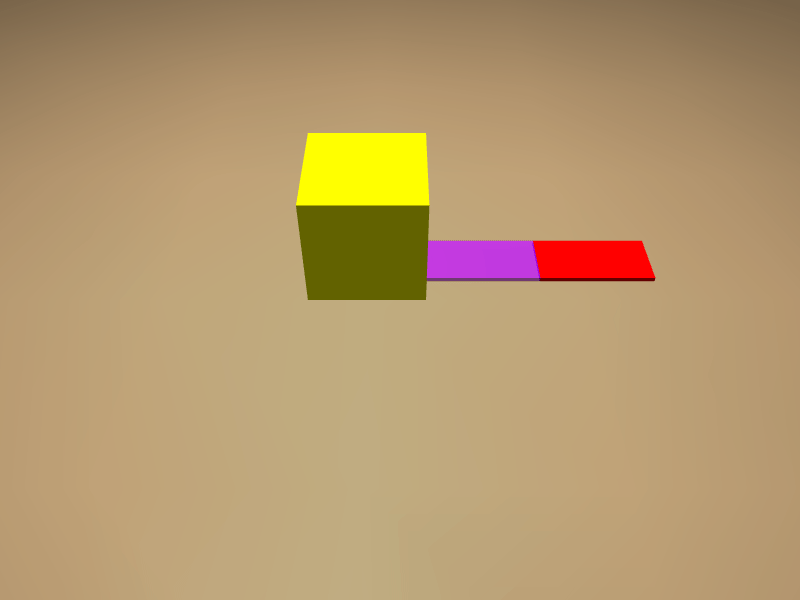

In [59]:
t,xy, frames = run_sim(1*10**-3, 1*10**-3/100,render=True)

In running the test I could see that the block does not go very high and to check the height it reached I simply plotted the z data with respect to time. and found that it only rose 0.08ish meters off of the ground 

In [60]:
plt.plot(t,xy[:,2,2])

Error in callback <function _draw_all_if_interactive at 0x0000016A9A0C4D30> (for post_execute):


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

<Figure size 640x480 with 1 Axes>

### 1. Sweep through leg stiffness from 1e-3 to 1e1 and plot max height as function of k

To complete this step I created a list of z values and k values in advance, and created another arrayfrom -3 to 1 with and interval of 0.1. Next, I made a for loop to run through each step of size 0.1 within the list exps, next I created a k and b to represent what k and b would be at the exp value that corresponds to the current step in the list. I appended the ks list with the current k value, and finally ran the simulation with these k and b values. After the simulation ran, I found the max z value by taking the z vaue in every row on the z axis and utilizing the provided .max() function to find the largest z value in the list for this k and b. I then print the z value for reference later and append the zs list with the max z value. This whole thing runs over and over until each simulation is run from -e to 1 with step sizes of 0.1; so 40 times.

In [61]:
zs = []
ks = []
exps = numpy.r_[-3:1:.01]
for exp in exps:
    k = 10**(float(exp))
    ks.append(k)
    b = k/100
    t,xy,frames = run_sim(k,b,render=False)
    max_z = xy[:,2,2].max()
    #print(max_z)
    zs.append(max_z)

To complete this question I just had to plot the values of the ks and zs to visualize each maximum height in reference to the corresponding stiffness value. plt.semilogx is used to scale the x axis(k axis) of the plot to log format. I used markers to display each step in the for loop/each individual k and z value. 

In [62]:
mainplot = plt.semilogx(ks,zs, marker = ".",
            markersize = 5,
            color = "purple")


Error in callback <function _draw_all_if_interactive at 0x0000016A9A0C4D30> (for post_execute):


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

<Figure size 640x480 with 1 Axes>

Although it looks as if near k=10 gives the most height, this is only the case due to the simulation breaking down at that high of stiffness, in reality, the most height is attained between 10^-2 and 10^-1. Below is a render of what it looks like when the simulation breaks at 10^1 stiffness.

""

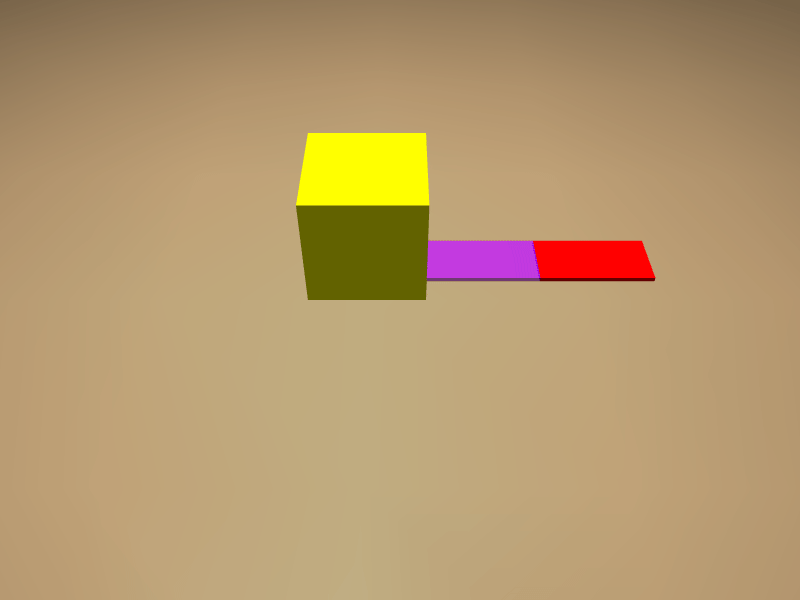

In [63]:
t, xy, frames=run_sim(1*10**1, 1*10**1/100,render=True)

Below is the video of the max height attained without breaking the simulation.

""

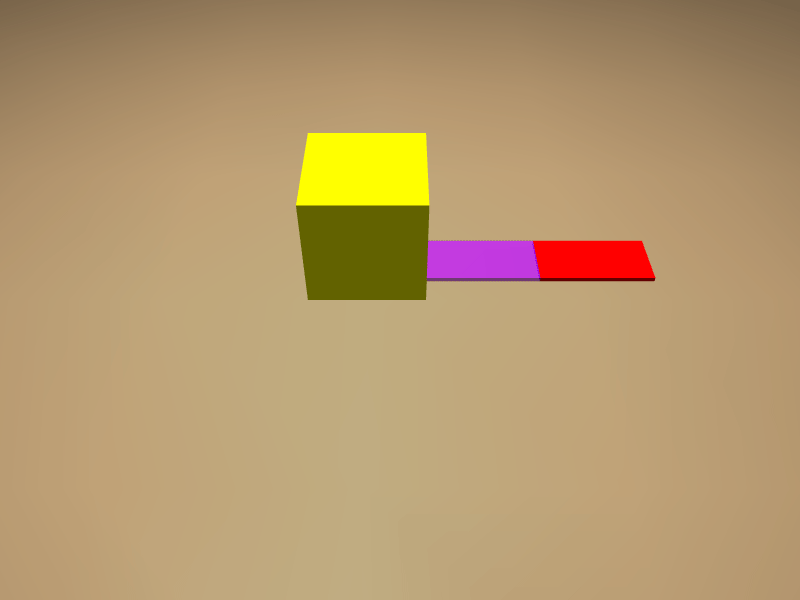

In [64]:
t, xy, frames=run_sim(2*10**-2, 2*10**-2/100,render=True)

In [65]:
plt.plot(t,xy[:,2,2])

Error in callback <function _draw_all_if_interactive at 0x0000016A9A0C4D30> (for post_execute):


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

<Figure size 640x480 with 1 Axes>

In [66]:
iis = numpy.r_[0:400:1]
for i in iis:
    print(zs[i])

0.07701944673657858
0.07700151666633763
0.07703502075744639
0.07700461691782122
0.07704337545739265
0.07703227561515824
0.07704783304603266
0.0770040656904965
0.07704537208597141
0.07706221140869708
0.07702989587734768
0.07700554143421261
0.07706311556345403
0.0770677063201603
0.07709011579292087
0.07702375486886823
0.0770431615017916
0.07706041258968721
0.07711698097261095
0.07710170789482175
0.07704901188049361
0.07716891804845348
0.07721640065960492
0.07720788475042585
0.07715902055835953
0.07721540614126192
0.07744314189996737
0.07736493392191354
0.07745862590825725
0.0775866792479698
0.07756345589344316
0.0778392539827389
0.07772226966365596
0.07808665163822454
0.0779717998036934
0.07842638140835884
0.07850700046684658
0.07870902007324503
0.07886905518383347
0.07919197239502378
0.07945731885143377
0.08002882109272308
0.08042582850197016
0.08071127052365942
0.0815189305965579
0.08203118684357677
0.08266783376956999
0.08358706835478415
0.08462318751788431
0.08579424816609377
0.08708

Due to the simulation break in the final 4 data points, I will truncate the list so that it only includes the datapoints that have reliable maximum heights.

In [67]:
del ks[370:]
del zs[370:]
print(ks)

[0.001, 0.0010232929922807535, 0.0010471285480508985, 0.0010715193052376049, 0.0010964781961431828, 0.0011220184543019607, 0.0011481536214968794, 0.0011748975549395256, 0.0012022644346174082, 0.001230268770812376, 0.001258925411794161, 0.001288249551693127, 0.0013182567385563993, 0.001348962882591645, 0.0013803842646028753, 0.001412537544622744, 0.001445439770745916, 0.001479108388168195, 0.0015135612484361949, 0.0015488166189124668, 0.0015848931924610978, 0.0016218100973589133, 0.0016595869074375426, 0.0016982436524617252, 0.001737800828749355, 0.001778279410038901, 0.0018197008586099603, 0.0018620871366628428, 0.001905460717963221, 0.0019498445997580176, 0.0019952623149688503, 0.002041737944669498, 0.0020892961308540065, 0.0021379620895021975, 0.002187761623949516, 0.0022387211385683013, 0.0022908676527677325, 0.0023442288153198796, 0.0023988329190194457, 0.0024547089156849835, 0.002511886431509531, 0.002570395782768812, 0.0026302679918953275, 0.002691534803926859, 0.0027542287033381

In [68]:
import scipy.optimize as optimize
import numpy as np

DaZs = zs
def max_k():
    maxp = 0
    def objective_function(zVal):
        return -zVal
    
    result = optimize.minimize_scalar(objective_function, bounds=(min(DaZs), max(DaZs)), method='bounded')
    #print(result.x)
    allks = numpy.r_[0:370:1]
    for kp in allks:
        #display(kp, round(result.x, 4) , round(zs[kp],4))
        if round(result.x,4) == round(zs[kp],4):
            #print("RIGHT HEREEE")
            maxp = kp
    return maxp

maxPoint = max_k()

print("Optimal Index:",maxPoint)
print("Optimal Stiffness:",ks[maxPoint])
print("Max Height:",zs[maxPoint])

Optimal Index: 133
Optimal Stiffness: 0.021379620895020924
Max Height: 0.14988179681789734


Above I wrote a function that takes the list of zs and performs a minimize function that makes all the zs negative so it finds the smallest(largest) z value. Then to find the index of that value in k and returned that value. Finally I printed the index, the value of k at that index, and the value of z at that index. Now I had the highest height that the box went for the optimal k value.

To plot the point on the origional plot, I simply plotted it again and added the new found optimal stiffness point. The optimal point is in red

In [69]:
plt.semilogx(ks,zs, marker = ".",
            markersize = 10,
            color = "purple")
plt.plot(ks[maxPoint],zs[maxPoint], "or")

Error in callback <function _draw_all_if_interactive at 0x0000016A9A0C4D30> (for post_execute):


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

<Figure size 640x480 with 1 Axes>

Here is the video of the optimal jump.

""

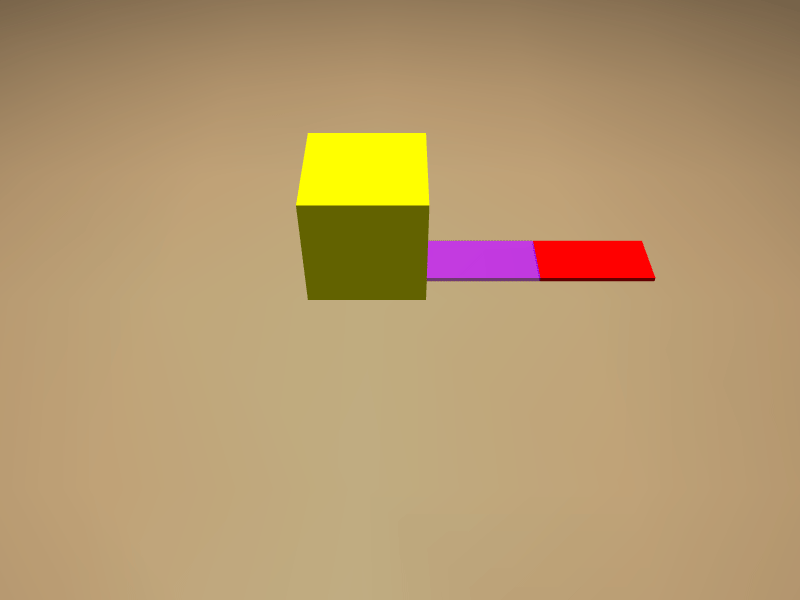

In [70]:
t,xy, frames = run_sim(ks[maxPoint], ks[maxPoint]/100,render=True)

Here is the graph of the height graph for the optimal jump

In [71]:
plt.plot(t,xy[:,2,2])

Error in callback <function _draw_all_if_interactive at 0x0000016A9A0C4D30> (for post_execute):


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss10.tfm' in your texmf tree, but could not find it

<Figure size 640x480 with 1 Axes>

I ended up using 0.01 instead of 0.1 as the step size in order to get a more accurate measurement of the max height.